<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [ ]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

import re
import datetime

In [2]:
import sys
is_colab = 'google.colab' in sys.modules

if is_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [ ]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'
if is_colab:
    PATH_TO_DATA = '/gdrive/My Drive/Colab Notebooks/Stepik/6_reg/capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [ ]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # ''' ВАШ КОД ЗДЕСЬ '''
    
    #Load Vocab
    with open(site_freq_path, 'rb') as handle:
        vocab_site = pickle.load(handle)   

    ses_n = 0
    np_f = np.zeros(15)    

    dtf = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    dtfunc = np.vectorize(dtf)    

    sf = lambda x: vocab_site[x][0]
    sfunc = np.vectorize(sf)

    for f in tqdm_notebook(glob(os.path.join(path_to_csv_files, '*.csv'))):        
        #getting user_id
        fn = os.path.basename(f)
        user_id = int(re.search(r'\d{4}', fn).group())        

        df = pd.read_csv(f)     
        f_np = df.to_numpy()

        f_np[:,0] = dtfunc(f_np[:,0])
        f_np[:,1] = sfunc(f_np[:,1])

        # numpy version
        for r in range(0, len(f_np), window_size):
            s = f_np[r:r+session_length]    
            ses_len = (s[:,0].max() - s[:,0].min()).seconds
            ses_h = s[:,0].min().hour
            ses_day = s[:,0].min().weekday()

            ses_s = s[:,1]
            ses_uniq = np.unique(ses_s).shape[0]
            if ses_s.shape[0] < 10:                   
                ses_s = np.append(ses_s, np.zeros(10-ses_s.shape[0]))

            # site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id 
            ses_r = np.concatenate((ses_s, [ses_len, ses_uniq, ses_h, ses_day, user_id]))
            np_f = np.vstack([np_f, ses_r])

    np_f = np.delete(np_f, 0, 0)
    
    return pd.DataFrame(np_f, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [5]:
# ['time_diff' + str(j) for j in range(1,10)] + \ #second row in feature_names
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,10,1,2,1,2,1,1,6,11,10,7998,5,9,4,3
1,10,1,2,0,0,0,0,0,0,0,1471,3,12,4,3
2,3,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
3,3,2,2,7,2,1,4,6,5,8,7998,8,9,4,1
4,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


CPU times: user 7.87 s, sys: 231 ms, total: 8.1 s
Wall time: 10.9 s


In [ ]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,60,60,269,60,60,1008,4,25,1017,103,1545,7,8,4,33
1,25,978,5,6,4,5,5,6,4,5,20,5,8,4,33
2,978,978,70,978,5,5,1376,5,1192,1192,1042,5,8,4,33
3,978,5,5,5,52,36,68,112,36,52,23,6,9,4,33
4,5,36,112,36,52,978,5,5,1192,4,2518,7,9,4,33


In [ ]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'wb') as new_features_10users_pkl:
          pickle.dump(train_data_10users.drop('target', axis=1), new_features_10users_pkl)

with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'wb') as target_10_users_pkl:
          pickle.dump(train_data_10users['target'], target_10_users_pkl)          

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [ ]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)


CPU times: user 15min 46s, sys: 12.5 s, total: 15min 59s
Wall time: 16min 39s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [ ]:
new_fe = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

train_data_10users[new_fe].head() #[train_data_10users[new_fe]].head()

,session_timespan,#unique_sites,start_hour,day_of_week
0,1545,7,8,4
1,20,5,8,4
2,1042,5,8,4
3,23,6,9,4
4,2518,7,9,4


In [ ]:
new_features_10users =  train_data_10users[new_fe]
new_features_150users = train_data_150users[new_fe]

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [ ]:
new_features_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [ ]:
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [ ]:
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [ ]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [ ]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [ ]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

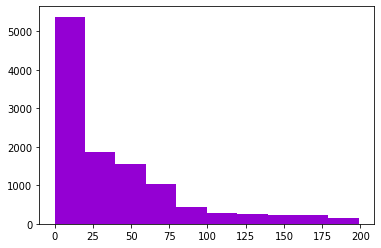

In [ ]:
# train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'].hist()
plt.hist(train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'],
         color='darkviolet')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

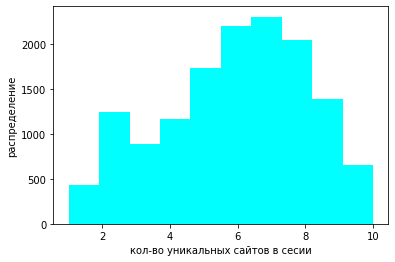

In [ ]:
plt.hist(train_data_10users['#unique_sites'], color='aqua')
plt.xlabel('кол-во уникальных сайтов в сесии')
plt.ylabel('распределение')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [ ]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,60,60,269,60,60,1008,4,25,1017,103,1545,7,8,4,Bob
1,25,978,5,6,4,5,5,6,4,5,20,5,8,4,Bob
2,978,978,70,978,5,5,1376,5,1192,1192,1042,5,8,4,Bob
3,978,5,5,5,52,36,68,112,36,52,23,6,9,4,Bob
4,5,36,112,36,52,978,5,5,1192,4,2518,7,9,4,Bob


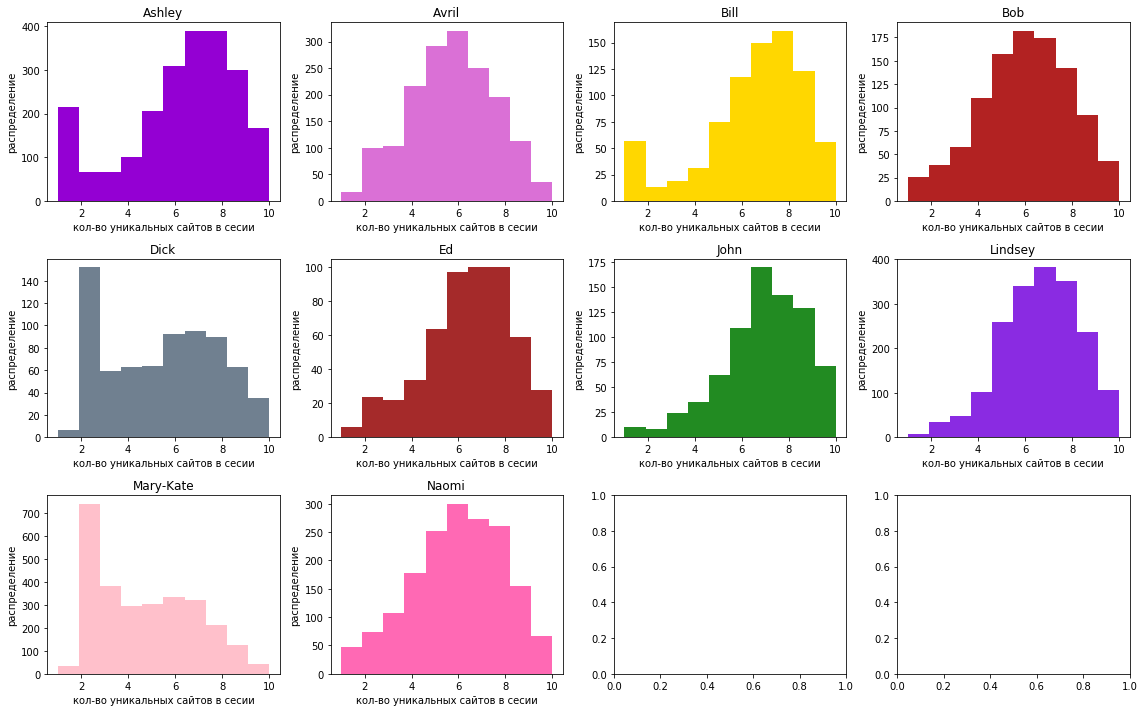

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
# for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    # ''' ВАШ КОД ЗДЕСЬ '''
    plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['#unique_sites'], color=color_dic[user])
    plt.title(user)
    plt.xlabel('кол-во уникальных сайтов в сесии')
    plt.ylabel('распределение')
    
plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

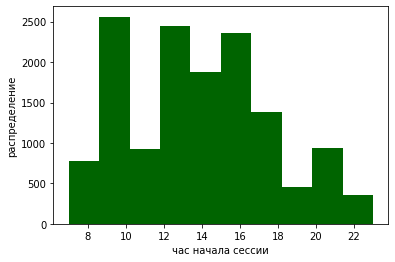

In [ ]:
plt.hist(train_data_10users['start_hour'], color='darkgreen')
plt.xlabel('час начала сессии')
plt.ylabel('распределение')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

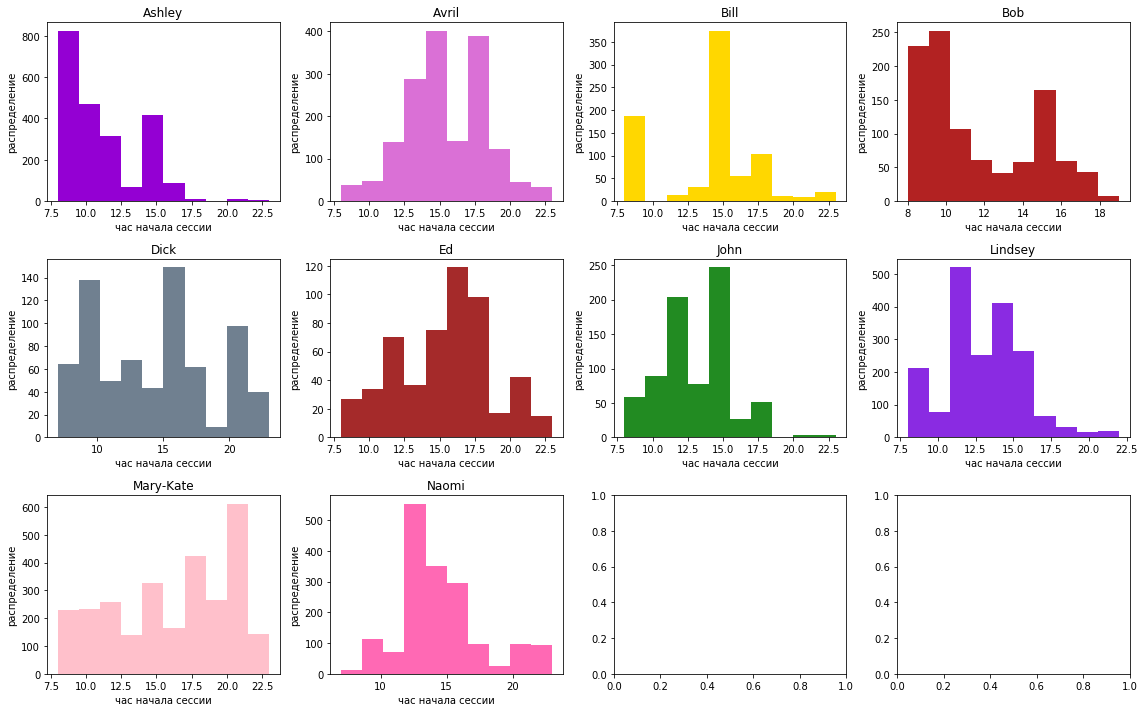

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
# for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
     #''' ВАШ КОД ЗДЕСЬ '''
    plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['start_hour'], color=color_dic[user])
    plt.title(user)
    plt.xlabel('час начала сессии')
    plt.ylabel('распределение')
    
plt.tight_layout()        

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

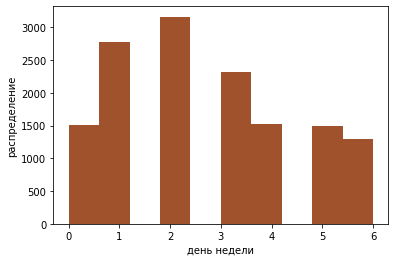

In [ ]:
plt.hist(train_data_10users['day_of_week'], color='sienna')
plt.xlabel('день недели')
plt.ylabel('распределение')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

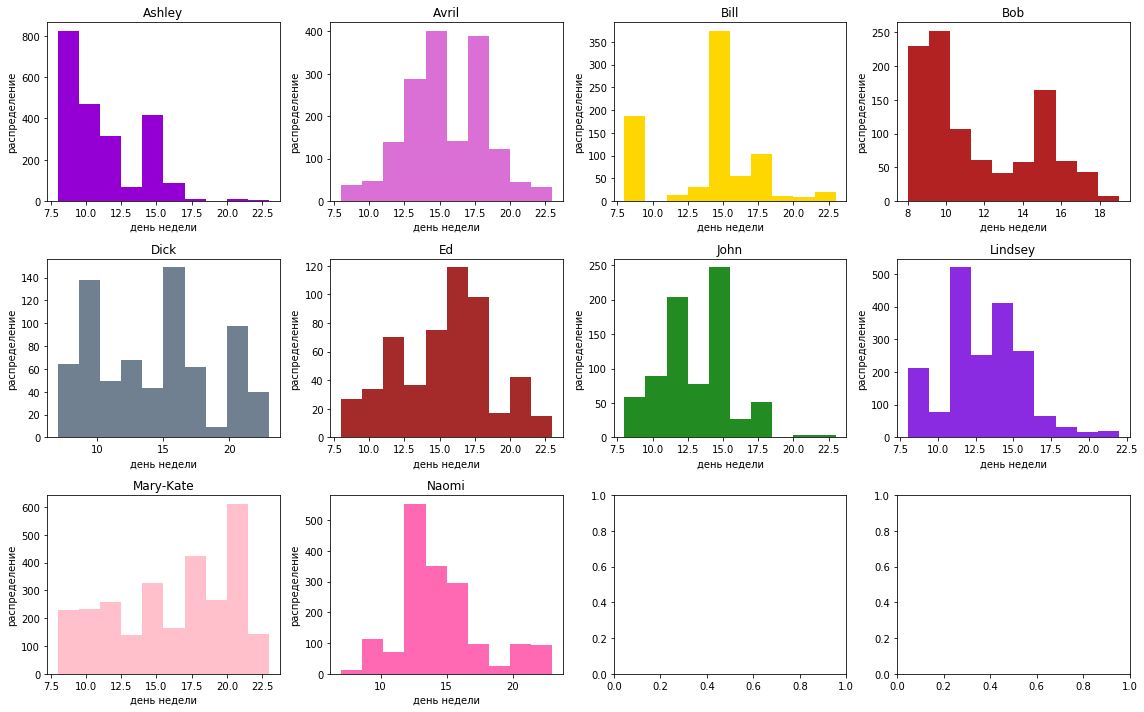

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
# for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
     #''' ВАШ КОД ЗДЕСЬ '''
    plt.subplot(3, 4, idx+1)
    plt.hist(sub_df['start_hour'], color=color_dic[user])
    plt.title(user)
    plt.xlabel('день недели')
    plt.ylabel('распределение')
    
plt.tight_layout()               

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [ ]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as handler:
    vocab_site = pickle.load(handler)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
vocab_site_df = pd.DataFrame(vocab_site).transpose()
vocab_site_df.head()

,0,1
webmail.laposte.net,1,399
plus.google.com,2,2630
live.lemde.fr,3,274
www.google.com,4,5441
www.google.fr,5,7813


In [ ]:
top10_df = vocab_site_df.sort_values(1, ascending=False)
top10_df = top10_df.iloc[:10]
top10_df

,0,1
s.youtube.com,69,8300
www.google.fr,5,7813
www.google.com,4,5441
mail.google.com,7,4158
www.facebook.com,8,4141
apis.google.com,6,3758
r3---sn-gxo5uxg-jqbe.googlevideo.com,262,3244
r1---sn-gxo5uxg-jqbe.googlevideo.com,914,3094
plus.google.com,2,2630
accounts.google.com,17,2089


In [ ]:
top10_freqs = top10_df[1].to_list()
top10_sites = top10_df.index.to_list()

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

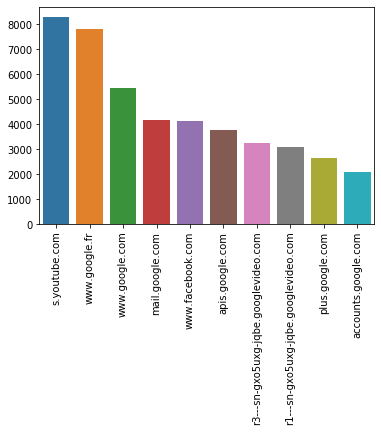

In [ ]:
g = sns.barplot(top10_sites, top10_freqs)
g.set_xticklabels(top10_sites, rotation=90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, site_freq_path,
                        features, session_length=10):

    #Load Vocab
    with open(site_freq_path, 'rb') as handle:
        vocab_site = pickle.load(handle)   

    ses_n = 0
    np_f = np.zeros(15)    

    dtf = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    dtfunc = np.vectorize(dtf)    

    sf = lambda x: vocab_site[x][0]
    sfunc = np.vectorize(sf)

    for f in tqdm_notebook(glob(os.path.join(path_to_csv_files, '*.csv'))):        
        #getting user_id
        fn = os.path.basename(f)
        user_id = int(re.search(r'\d{4}', fn).group())        

        df = pd.read_csv(f)     
        f_np = df.to_numpy()

        f_np[:,0] = dtfunc(f_np[:,0])
        f_np[:,1] = sfunc(f_np[:,1])

        # numpy version
        for r in range(0, len(f_np), window_size):
            s = f_np[r:r+session_length]    
            ses_len = (s[:,0].max() - s[:,0].min()).seconds
            ses_h = s[:,0].min().hour
            ses_day = s[:,0].min().weekday()

            ses_s = s[:,1]
            ses_uniq = np.unique(ses_s).shape[0]
            if ses_s.shape[0] < 10:                   
                ses_s = np.append(ses_s, np.zeros(10-ses_s.shape[0]))

            # site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id 
            ses_r = np.concatenate((ses_s, [ses_len, ses_uniq, ses_h, ses_day, user_id]))
            np_f = np.vstack([np_f, ses_r])

    np_f = np.delete(np_f, 0, 0)
    
    return pd.DataFrame(np_f, columns=features)    

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 